In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

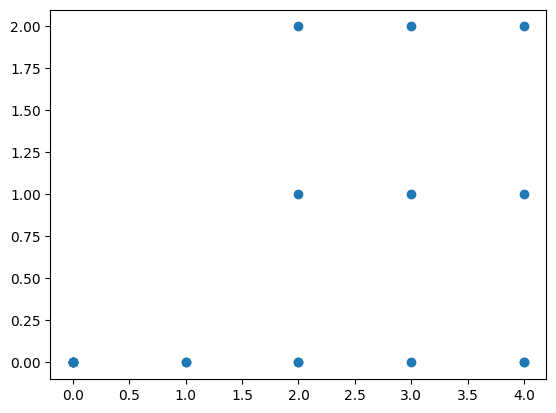

In [6]:
scorpio_data = pd.read_csv("X8Scorpio8X_Data")

plt.scatter(scorpio_data['dragonKills'], scorpio_data['baronKills'])

plt.show()